In [1]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm
from IPython.display import display, Math

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

C:\Users\abel_\anaconda3\envs\CIT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load model
#list experiment folders

# exp_list = glob.glob(current_dir+"\\experiments\\perceptual_discrimination\\*")
exp_list = glob.glob(current_dir+"\\experiments\\poisson_clicks\\exp*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))

last_i = 8
exp_list[-last_i]

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\exp_single_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec4_1655981969'

In [3]:
# exp_path = current_dir + '\\experiments\\perceptual_discrimination\\exp_learningrate0.0001_20_accuracygoal0.95_maxepochs200_Nrec2_1656414475' #
exp_path = exp_list[-last_i]
idx = exp_path[-10:]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

idx = int(re.search(r'\d+', exp_path).group())

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)

# file = train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

In [4]:
Nrec = training_kwargs['N_rec']
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\exp_single_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec4_1655981969'

Losses

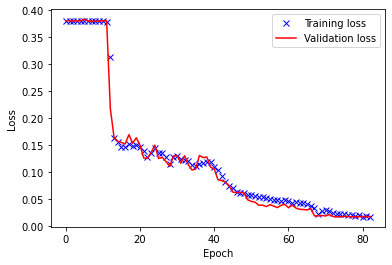

In [5]:
with open(training_kwargs['exp_path'] + '/learning_info.pickle', 'rb') as handle:
    learning_info = pickle.load(handle)
epoch_counter = 0
losses = learning_info['training_loss']
plt.plot(range(epoch_counter, epoch_counter+len(losses)), losses, 'bx', label="Training loss")
val_losses = learning_info['validation_loss']
plt.plot(range(epoch_counter, epoch_counter+len(losses)), val_losses, 'r', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0, max([losses[0], val_losses[0]])])
# plt.ylim([0, 1])
plt.legend(['Training loss', 'Validation loss'])
plt.savefig(training_kwargs['figures_path'] + '/losses_opt'+training_kwargs['optimizer']+'lr'+str(training_kwargs['learning_rate'])+'.pdf')

 <font size="10">Weights  <font>

In [6]:
rnn_model.state_dict().keys()
# row_labels = ['Z', 'Y', 'X', 'W']
# column_labels = []
# df = pandas.DataFrame(x)
import pandas
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key]) for key in rnn_model.state_dict().keys()}

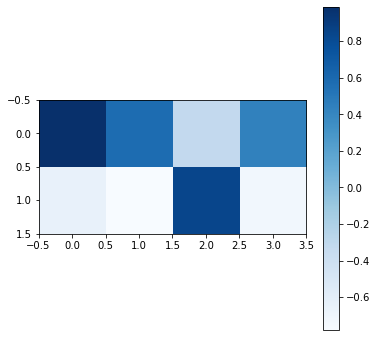

In [7]:
#input weights
W_ih = weights_dict['rnn.weight_ih_l0'] 

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ih.T, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [8]:
print("W_in=")
print(W_ih)
b_in = weights_dict['rnn.bias_ih_l0']
print("\n b_in:")
print(b_in)

W_in=
          0         1
0  0.987389 -0.649964
1  0.574165 -0.779098
2 -0.316834  0.836217
3  0.430085 -0.730390

 b_in:
          0
0  0.503136
1 -0.306422
2 -0.012261
3 -0.122586


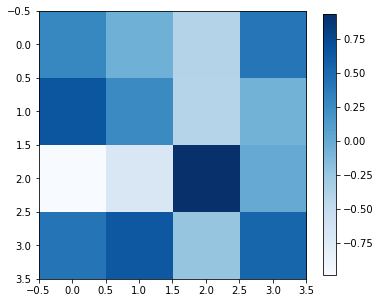

In [9]:
#recurrence weights
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_hh, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.5), shrink=0.8);

In [10]:
print("W_h=")
print(W_hh)
b_h = weights_dict['rnn.bias_hh_l0']
print("\n b_h:")
print(b_h)

W_h=
tensor([[ 2.8879e-01, -4.3659e-02, -3.9584e-01,  4.1153e-01],
        [ 6.4639e-01,  2.5885e-01, -4.0543e-01, -7.2167e-02],
        [-9.8602e-01, -6.9932e-01,  9.2993e-01, -5.5417e-04],
        [ 4.2743e-01,  6.3544e-01, -2.2780e-01,  5.3995e-01]])

 b_h:
          0
0 -0.271748
1  0.228582
2  0.134356
3 -0.135849


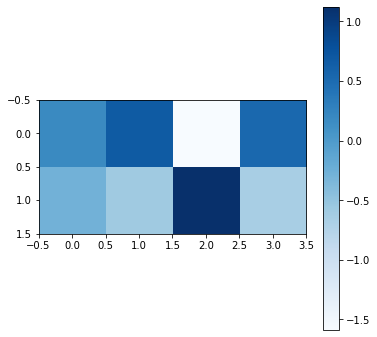

In [11]:
#output weights
W_ho = rnn_model.state_dict()['fc.weight'] 
fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ho, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [12]:
print("W_out=")
print(W_ho)
print("\n b_out:")
print(weights_dict['fc.bias'])

W_out=
tensor([[ 0.1895,  0.6682, -1.5868,  0.5373],
        [-0.2821, -0.5818,  1.1223, -0.6593]])

 b_out:
          0
0 -0.794227
1  0.988851


# Analytical

In [13]:
b = b_in + b_h
b = b[0].to_numpy()

try:
    W_hh = W_hh.numpy()
    b = b[0].to_numpy()
    W_ih = W_ih.to_numpy()
except:
    0
print("Effective b=", b)

Effective b= [ 0.23138812 -0.07784033  0.12209474 -0.25843534]


In [14]:
def lu_step(x, W, b):
    return x*W+b

def relu_step(x, W, b):
    res = np.array(np.dot(W,x)+b)
    res[res < 0] = 0
    return res
 
def relu_step_input(x, W, b, W_ih, I):
    res = np.array(np.dot(W,x) + b + np.dot(W_ih, I))
    res[res < 0] = 0
    return res

#intersection with x-axis:
print(r"$x_0$: ", -b/W_hh.diagonal())

#intersection with diagonal line:
x_s = b/(1-W_hh.diagonal())
print(r"$x$: ", x_s)

$x_0$:  [-0.8012372   0.30072013 -0.13129453  0.47863156]
$x$:  [ 0.32534364 -0.10502591  1.7424719  -0.5617504 ]


In [15]:
xmin, xmax = -10, 20
x = np.linspace(xmin, xmax, 100)

xlu =  np.linspace(-b/W_hh.diagonal(), xmax, 100)
xslope = xlu*W_hh.diagonal() + b
xflat = np.linspace(xmin, -b/W_hh.diagonal(), 100)
yflat = np.zeros(100)

xslope.shape

(100, 4)

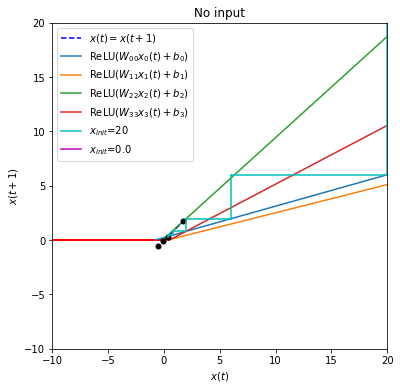

In [393]:
#NOTE: should not extend beyond x(t+1)<0
plt.figure(figsize=(6,6))
plt.plot(x, x, '--b', label="$x(t)=x(t+1)$")

plt.plot(xflat, yflat, 'r')
# plt.plot(xlu[:,0], xslope[:,0], 'r', label="ReLU($W_{11}x_1(t)+b_1$)")
# plt.plot(xlu[:,1], xslope[:,1], 'orange', label="ReLU($W_{22}x_2(t)+b_2$)")
# plt.plot(xlu[:,2], xslope[:,2], 'yellow', label="ReLU($W_{33}x_3(t)+b_3$)")
for i in range(xlu.shape[-1]):
     plt.plot(xlu[:,i], xslope[:,i], label="ReLU($W_{%s%s}x_%s(t)+b_%s$)"%(i,i,i,i))
plt.plot(x_s, x_s, 'ko', markersize=5, label='')

# #plot paths
x_start = 20 #towards 
xs = [x_start]
for i in range(100):
    xs.append(relu_step(xs[-1], W_hh[0][0], b[0]))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'c')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'c')
plt.plot([xt1, xs[i]], [xt1, xt1], 'c', label='$x_{init}$=%s'%x_start)

x_start = .0
xs = [x_start]
for i in range(100):
    xs.append(relu_step(xs[-1], W_hh[1][1], b[1]))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'm')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'm')
plt.plot([xt1, xs[i]], [xt1, xt1], 'm', label='$x_{init}$=%s'%x_start)
    
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title("No input")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+1)$");
plt.legend()

plt.savefig(training_kwargs['figures_path'] + "activation_plot_%s.pdf"%training_kwargs['N_rec'])

## Fixed points from dynamics

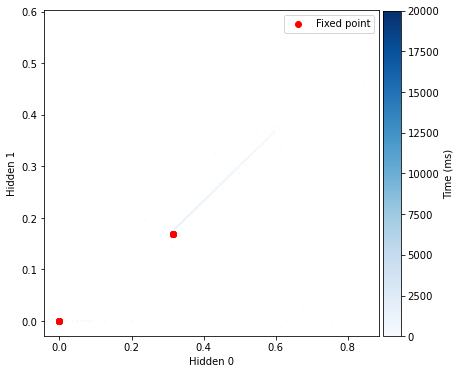

In [376]:
#scanning hidden space dynamics with random starting points 
#zero inputs
std = 1. # rnn_model.hidden_initial_variance
batch_size = 10
maxT = 2000
inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
hidden = torch.normal(mean=0, std=std, size=(rnn_model.n_layers, batch_size, rnn_model.hidden_dim))
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()

fig = plt.figure(figsize=(6,6))
cmap = cm = plt.get_cmap('Blues') 
for i in range(batch_size):
    sc = plt.scatter(hidden_states[i,:,0],
                     hidden_states[i,:,1],
                     s=1, vmin=0, vmax=maxT*10, cmap=cmap,
                     c=np.linspace(0, maxT*10, hidden_states.shape[1]))
    
plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1], c='r', label='Fixed point')
plt.xlabel("Hidden 0")
plt.ylabel("Hidden 1")
plt.legend()
cb_ax = fig.add_axes([.91,.124,.04,.754])
plt.colorbar(sc, cax=cb_ax).set_label('Time (ms)',rotation=90)
plt.savefig(training_kwargs['figures_path'] + "\\hidden_trajectories_randominit.pdf")

In [377]:
#scanning hidden space dynamics with starting points from grid
#zero inputs
maxT = 200
step = 5
max_grid = 20
Ngrid = int(max_grid/step)
grid= np.mgrid[tuple(slice(0, max_grid, step) for _ in range(Nrec))].reshape((1, int((Ngrid)**Nrec), Nrec))

batch_size = int((Ngrid)**Nrec)
inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
hidden = torch.tensor(grid, dtype=torch.float)
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()

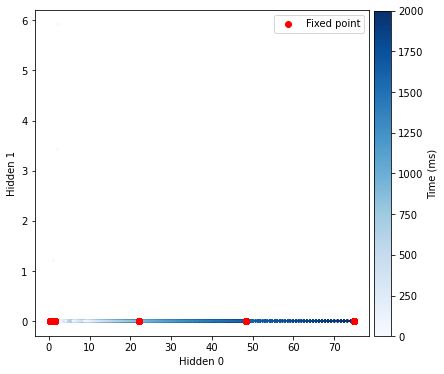

In [380]:
fig = plt.figure(figsize=(6,6))
cmap = cm = plt.get_cmap('Blues') 
for i in range(batch_size):
    sc = plt.scatter(hidden_states[i,:,0],
                     hidden_states[i,:,2],
                     s=2, vmin=0, vmax=maxT*10, cmap=cmap,
                     c=np.linspace(0, maxT*10, hidden_states.shape[1]))
    
plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,2], c='r', label='Fixed point')
plt.xlabel("Hidden 0")
plt.ylabel("Hidden 1")
plt.legend()
cb_ax = fig.add_axes([.91,.124,.04,.754])
plt.colorbar(sc, cax=cb_ax).set_label('Time (ms)',rotation=90)
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_gridinit.pdf")

## Nullclines 

In [367]:
#intersection of nullclines:

#restrict ranges to find true fixed points
minx2 = -b[1]/W_hh[1][1]
minx1 = -b[0]/W_hh[0][0]

Nsteps= 100
def nullcline(x, W_ii, W_ij, b_i):
    return -1/W_ij*((W_ii-1)*x+b_i)

def slope_intercept(W_ii, W_ij, b_i):
    slope =  -1/W_ij*(W_ii-1)
    intercept = -1/W_ij*b_i
    return slope, intercept

m1, c1 =  slope_intercept(W_hh[0,0], W_hh[1][0], b[0])
m2, c2 =  slope_intercept(W_hh[1,1], W_hh[0][1], b[1])
m2 = 1/m2
c2 = -c2*m2
xi = (c1 - c2) / (m2 - m1)

xi
# yi1 = nullcline(xi, W_hh[1,1], W_hh[0][1], b[1])
yi = nullcline(xi, W_hh[0,0], W_hh[1][0], b[0])
xi, yi

(0.21820712758815802, -0.11787979450381675)

IndexError: list index out of range

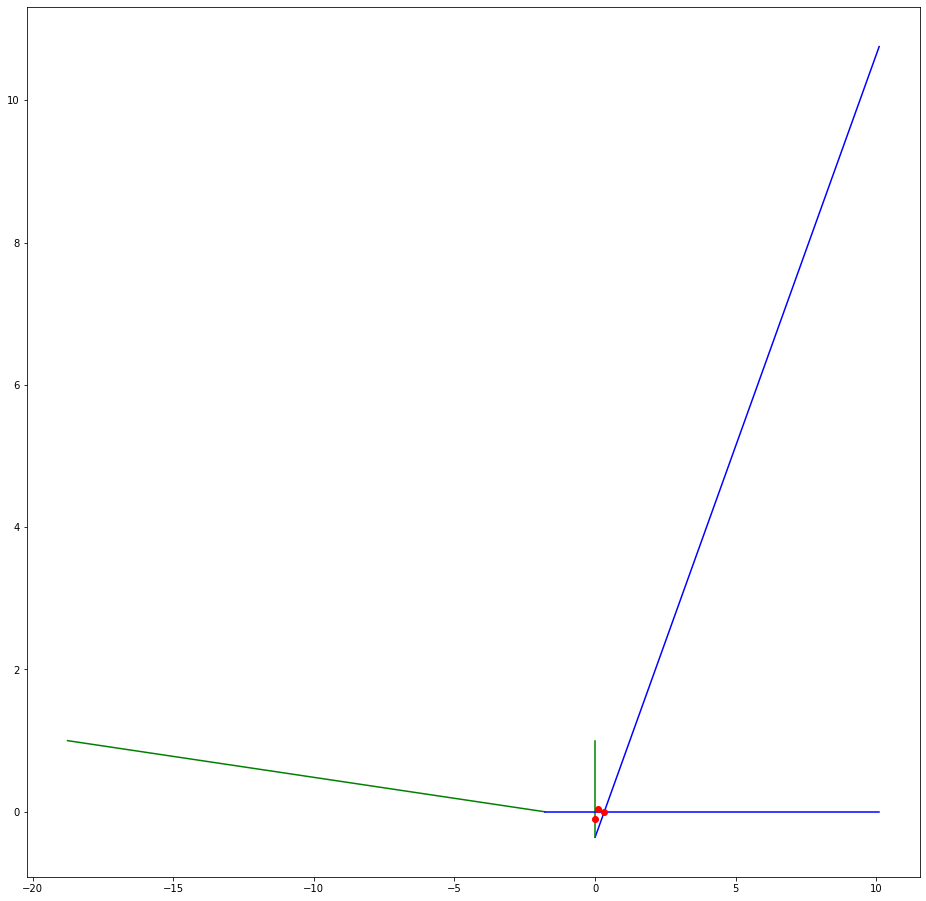

In [368]:
fig = plt.figure(figsize=(16,16))
cmap = cm = plt.get_cmap('Blues') 

xmin, xmax = 0, 10.1
x1 = np.linspace(xmin, xmax, Nsteps)
x2 = nullcline(x1, W_hh[0,0], W_hh[1][0], b[0])
plt.plot(x1, x2, 'b', zorder=0)

xmin, xmax = 0, 1
x2 = np.linspace(xmin, xmax, Nsteps)
x1 = nullcline(x2, W_hh[1,1], W_hh[0][1], b[1])
plt.plot(x1, x2, 'g', zorder=0)

xmin, xmax = 0, 1.
x1 = np.zeros(Nsteps)
x2 = np.linspace(-b[0]/W_hh[1][0], xmax, Nsteps)#W_hh[1][0]<0
plt.plot(x1, x2, 'g')

xmin, xmax = 0, 10.1
x2 = np.zeros(Nsteps)
x1 = np.linspace(-b[1]/W_hh[0][1], xmax, Nsteps)
plt.plot(x1, x2, 'b')

# plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1], c='r', label='Fixed point', zorder=2)
fpnt = -np.dot(np.linalg.inv(W_hh-np.eye(Nrec)), b)
plt.scatter(fpnt[0], fpnt[1], c='r', zorder=2)
for i in range(Nrec):
    fpnt = [0,-b[i]/(W_hh[i,i]-1 )]
    plt.scatter(fpnt[i-1], fpnt[i], c='r', zorder=2)

# plt.scatter([xi], [yi], c='r', label='Fixed point')

xx = np.arange(0, 10.2, 1)
yy = np.arange(0, 10.5, 1)
(XX, YY) = np.meshgrid(xx, yy)

dX = W_hh[0][0]*XX+W_hh[0][1]*YY+b[0]
dX[dX < 0] = 0
dX -= XX
dY = W_hh[1][0]*XX+W_hh[1][1]*YY+b[1]
dY[dY < 0] = 0
dY -= YY
vel = np.sqrt(dX**2 + dY**2)

# Use quiver function to plot the phase plane
plt.quiver(XX, YY, dX, dY) 
    
plt.xlabel("Hidden 0")
plt.ylabel("Hidden 1")
plt.legend()
plt.savefig(training_kwargs['figures_path'] + "\\nullcline_vectorfield.pdf")

In [62]:
unstable_fixedpoint = -np.dot(np.linalg.inv(W_hh-np.eye(Nrec)), b)

In [16]:
#test found fixed points
# [xi,yi], relu_step([xi,yi], W_hh, b) #not a fixed point
# # because:
# np.array(np.dot(W_hh,[xi,yi])+b)
# second component is not positive (which was the assumption for this part of the nullcline)

#improvement: draw nullcline until assumption holds
# find intersection with axis:

In [17]:
fun = partial(relu_step, W=W_hh, b=b)
results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-12,
                            maxiter = 10000, method='Nelder-Mead')

fixed_points = np.unique(results, axis=0)

TypeError: __init__() missing 2 required positional arguments: 'lb' and 'ub'

In [18]:
#zero inputs
fig = plt.figure(figsize=(6,6))
batch_size = 1
maxT = 2000
for x in fixed_points[:]:
    inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
    hidden = torch.tensor(x, dtype=torch.float) * torch.ones(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
    hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()
    plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1])
    print(hidden_states[:,-1,:], -x+relu_step(x, W_hh, b))

NameError: name 'fixed_points' is not defined

<Figure size 432x432 with 0 Axes>

In [22]:
tol=10**-7
fun = partial(relu_step, W=W_hh, b=b)
results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-7,  maxiter = 10000,
                      method='Nelder-Mead')
fixed_points = np.unique(results, axis=0)
fixed_points = np.round(fixed_points, 7)
fixed_points = np.unique(fixed_points, axis=0)
# pos_fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > 0, fixed_points[:, 1] > 0), :]
nfxdpnts = [len(fixed_points)]
stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-4)
stabilist = np.array(stabilist)
fixed_points

#test found fixed points
I=[0,0]
for fxd in fixed_points:
    print(fxd-relu_step_input(fxd, W_hh, b, W_ih, I)) #f(x) = -x + ReLU(Wx+b+I)

[0.00000000e+00 0.00000000e+00 8.21727575e-10 0.00000000e+00]
[4.44600000e-04 3.00000000e-07 3.35362733e-08 0.00000000e+00]
[-2.09722534e-08  1.49100000e-04 -5.16275644e-08  0.00000000e+00]
[-6.90930035e-09  2.85898954e-08  6.11192000e-02  0.00000000e+00]
[4.00155418e-04 4.98192010e-09 0.00000000e+00 0.00000000e+00]
[-2.09376455e-08 -1.32459595e-01  0.00000000e+00  0.00000000e+00]
[-4.12043601e-08  3.79530132e-08  0.00000000e+00  2.40417302e-08]
[-3.08714210e-09 -3.86733134e-03  0.00000000e+00  4.77694873e-09]
[ 3.25458274e-08  1.56333621e-05  2.50920000e-03 -1.00102872e-03]
[ 7.63893127e-09 -4.54450855e-09  2.31270000e-02 -1.83997521e-03]
[-3.88378617e-02 -2.22352312e-06  0.00000000e+00 -5.49015517e-08]
[-1.03397781e-01 -5.58389068e-09  0.00000000e+00 -4.38211734e-08]


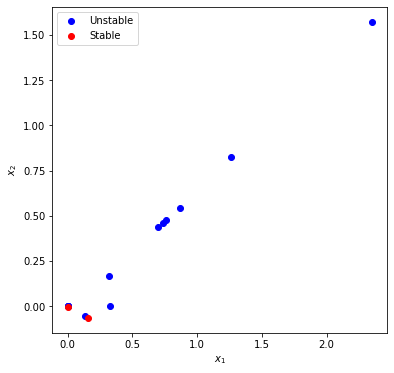

In [385]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
stabilist = np.array(stabilist)
for st in np.unique(stabilist):
    idx = np.where(st==stabilist, True, False)
    sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
    
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_gridinit_noinput_stabilities.pdf")

[-3.47100000e-04  9.12900000e-04 -5.17384291e-08 -0.00000000e+00]
[-0.00000000e+00  2.85380000e-03  8.05180456e-09 -1.21714000e-02]
[-0.          0.0012567  -0.00049172  0.0001915 ]
[ 0.00000000e+00 -1.19360000e-03 -2.44245325e-03 -4.90000000e-06]
[ 1.58770000e-03 -6.71600000e-04 -2.12505731e-05 -0.00000000e+00]
[-2.12031767e-08 -5.36041000e-02  8.13041747e-08  0.00000000e+00]
[-0.12940989 -0.07783905 -0.0153221  -0.        ]
[2.95113131e-08 5.69917604e-08 4.40340000e-03 5.13450000e-03]
[-2.59347752e-08 -1.30115554e-01  3.49400000e-04 -1.20000000e-06]
[-1.03142440e-08 -8.18421098e-09 -1.75750000e-03 -1.51406544e-03]
[-1.84547110e-03  6.06129805e-05 -1.07310000e-03 -2.24075659e-08]
[-3.28006410e-03  2.57868279e-03  0.00000000e+00  2.41996169e-08]
[-4.92121830e-08 -6.18073438e-03  1.60160000e-03 -6.01341856e-07]
[-1.82424894e-02  5.05254328e-08  0.00000000e+00 -4.21866775e-08]
[-5.36846803e-02 -3.94398645e-08  0.00000000e+00 -6.43008683e-05]


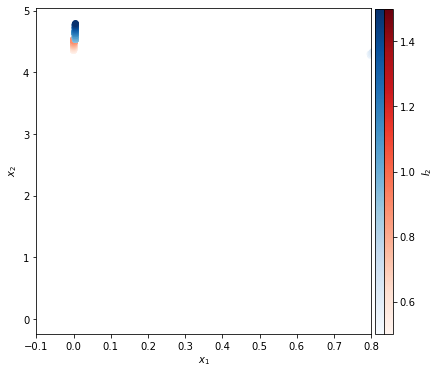

In [70]:
#NUMERICAL FXD PNTS
tol=10**-7
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]
eps = .5
Nepspoints = 501 #int(eps*1000+1)
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
fixed_point_list = []
numberof_fixedpoints = []
for i, I2 in enumerate(I2s):
    I = np.array([1.,I2])
    fun = partial(relu_step_input, W=W_hh, b=b, W_ih=W_ih, I=I)
    results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = tol,  maxiter = 10000,
                      method='Nelder-Mead')
    fixed_points = np.round(results, 4)
    fixed_points = np.unique(fixed_points, axis=0)
    fixed_point_list.append(fixed_points)
    fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > -tol, fixed_points[:, 1] > -tol), :]
    nfxdpnts = [len(fixed_points)]
    stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-7)
    stabilist = np.array(stabilist)
    scs = [0,0]
    for st in [0,1]:
        idx = np.where(st==stabilist, True, False)
        # sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st])
        scs[st] = ax.scatter(fixed_points[idx,0], fixed_points[idx,1],
                         vmin=1-eps, vmax=1.+eps,
                         cmap=cmaps[st], c=[1-eps+2*i*eps/Nepspoints]*sum(idx))
        nfxdpnts.append(sum(idx))
    numberof_fixedpoints.append(nfxdpnts)
    
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-0.1, 0.8])
# ax.set_title("No input")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_I2inputs_eps%s.pdf"%eps)

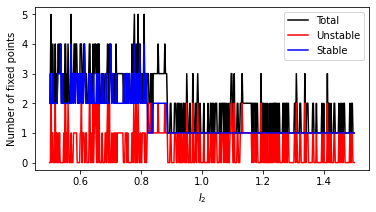

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
for i, nfpnts in enumerate(np.array(numberof_fixedpoints).T):
    plt.plot(I2s, nfpnts, label=labellist[i], color=colorlist[i])
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_noinput_eps%s.pdf"%eps)

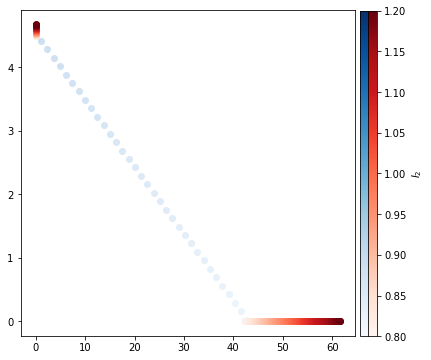

In [81]:
#ANALYTICAL FXD PNTS
tol=10**-7
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]
eps = .2
Nepspoints = int(eps*1000+1)
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
fixed_point_list = []
numberof_fixedpoints = []
scs = [0,0]
for j, I2 in enumerate(I2s):
    I = np.array([1.,I2])
    fpnt = -np.dot(np.linalg.inv(W_hh-np.eye(Nrec)), b+np.dot(W_ih,I))
    nfxdpnts = [0]*3
    if np.all(fpnt>=0):
        stabilist = find_stabilities([fpnt], W_hh=W_hh, tol = 10**-7)[0]
        scs[0] = ax.scatter(fpnt[i-1], fpnt[i], cmap=cmaps[stabilist], vmin=1-eps, vmax=1+eps, c=1-eps+2*j*eps/Nepspoints, zorder=2)
        nfxdpnts[stabilist-2] += 1
    for i in range(Nrec):
        fpnt = np.array([0,-(b[i]+np.dot(W_ih,I)[i])/(W_hh[i,i]-1)])
        if np.all(fpnt>=0.):
            stabilist = find_stabilities([fpnt], W_hh=W_hh, tol = 10**-7)[0]
            scs[1] = ax.scatter(fpnt[i-1], fpnt[i], cmap=cmaps[stabilist], vmin=1-eps, vmax=1+eps, c=1-eps+2*j*eps/Nepspoints, zorder=2)
            nfxdpnts[stabilist-2] += 1
    nfxdpnts[0] = nfxdpnts[1] + nfxdpnts[2]
    numberof_fixedpoints.append(nfxdpnts)
    
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
# ax.set_xlabel("$x_1$")
# ax.set_ylabel("$x_2$")
# ax.set_xlim([-0.1, 0.8])
# # ax.set_title("No input")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_I2inputs_analytical_eps%s.pdf"%eps)

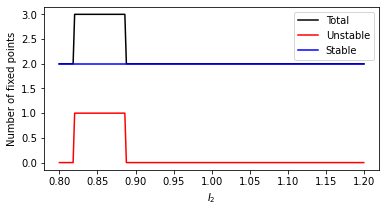

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
for i, nfpnts in enumerate(np.array(numberof_fixedpoints).T):
    plt.plot(I2s, nfpnts, label=labellist[i], color=colorlist[i])
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_noinput_analytical_eps%s.pdf"%eps)

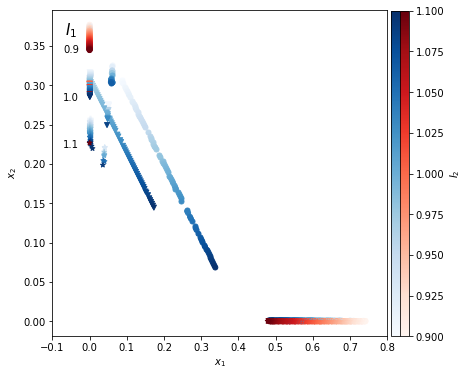

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]
markerlist = ["o", "v", "*"]
eps = .1
Nepspoints = 101
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
I1s = [1-eps, 1., 1+eps]
numberof_fixedpoints_I1 = []
fixed_point_list_I1 = []
matplotlib.pyplot.text(-0.05, 0.37, "$I_1$", fontsize=15, horizontalalignment='center', verticalalignment='center')
for j, I1 in enumerate(I1s):
    numberof_fixedpoints = []
    scs = [0,0]
    fixed_point_list = []
    for i, I2 in enumerate(I2s):
        
        I = np.array([I1,I2])
        fun = partial(relu_step_input, W=W_hh, b=b, W_ih=W_ih, I=I)
        results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-4,  maxiter = 10000,
                      method='Nelder-Mead')
        fixed_points = np.round(results, 4)
        fixed_points = np.unique(fixed_points, axis=0)
        fixed_point_list.append(fixed_points)
        fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > -tol, fixed_points[:, 1] > -tol), :]
        nfxdpnts = [len(fixed_points)]
        stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-7)
        stabilist = np.array(stabilist)
        for st in [0,1]:
            idx = np.where(st==stabilist, True, False)
            # sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st])
            scs[st] = ax.scatter(fixed_points[idx,0], fixed_points[idx,1],
                            s=25, marker=markerlist[j],
                             vmin=1-eps, vmax=1.+eps,
                             cmap=cmaps[st], c=[1-eps+2*i*eps/Nepspoints]*sum(idx))
            nfxdpnts.append(sum(idx))
        numberof_fixedpoints.append(nfxdpnts)
    ycoord = np.max([np.max(np.array(fixed_points[:,1])) for fixed_points in fixed_point_list])
    matplotlib.pyplot.text(-0.05, 0.345-j*0.06, str(I1),
    horizontalalignment='center',
     verticalalignment='center')
    fixed_point_list_I1.append(fixed_point_list)
    numberof_fixedpoints_I1.append(numberof_fixedpoints)
    
# plt.legend(labellist)
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-0.1, 0.8])
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_bothinputs_eps%s.pdf"%eps)

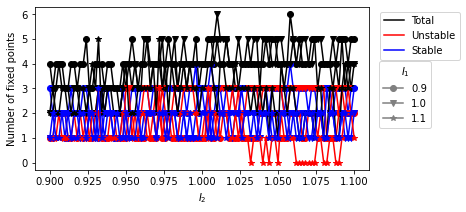

In [38]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
markerlist = ["o", "v", "*"]
lines_I1 = []
for j,numberof_fixedpoints in enumerate(numberof_fixedpoints_I1):
    lines_I2 = []
    for i,nfpnts in enumerate(np.array(numberof_fixedpoints).T):
        lineplot = plt.plot(I2s, nfpnts, label=labellist[i], color=colorlist[i], marker=markerlist[j])
        lines_I2.append(lineplot)
    lines_I1.append(lines_I2)
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")

colors_legend_list = []
for i, label in enumerate(labellist):
    line = mlines.Line2D([], [], color=colorlist[i], linewidth=1.5, label=label)
    colors_legend_list.append(line)
    
markers_legend_list = []
for i, label in enumerate(labellist):
    line = mlines.Line2D([], [], color='grey', marker=markerlist[i], linewidth=1.5, label=I1s[i])
    markers_legend_list.append(line)

# line_solid = plt.ploy([], [], color='black', linestyle='-', linewidth=1.5, label=r'$n_\beta = n_o$')
# line_dashed = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1.5, label=r'$n_\beta = n_o/2$')

first_legend = plt.legend(handles=colors_legend_list,bbox_to_anchor=(0.785, 0.50, 0.5, 0.5))
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=markers_legend_list,
                           bbox_to_anchor=(0.7, 0.20, 0.5, 0.5)) #best upper-right
second_legend.set_title("$I_1$")

plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_inputs_eps%s.pdf"%eps)

# Dynamics

In [278]:
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\%s.pickle"%, 'rb') as handle:
#     data_set = pickle.load(handle)
# x, y, output_mask, trial_params = data_set

In [279]:
# #initialize hidden states
# inputs = torch.tensor(x, dtype=torch.float)
# hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
# hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
# hidden_states = hidden_states.detach().numpy()
# flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [343]:
# # hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
# # hidden_states = hidden_states.detach().numpy()
# directions = np.array([trial_params[i]['direction'] for i in range(trial_params.shape[0])])
# colors_list = ['b', 'r']
# for trial_i in range(10):
#     direction = directions[trial_i]
#     plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0], colors_list[direction])
# # plt.ylim([0,1]);
# plt.legend(['Left', 'Right'], title='Direction')
# ax = plt.gca()
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
# plt.xlabel("Time")
# plt.ylabel("Activity")
# # plt.ylim([0,1])
# plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_10.pdf')

<!-- ###PCA for one coherence data -->
<font size=5>PCA<font>

In [344]:
#PCA for various ratios data
test_kwargs_left = training_kwargs
min_ratio = 1.1
max_ratio = 2
test_kwargs_left['ratios'] = np.array([np.linspace(min_ratio, max_ratio, 3), np.linspace(-max_ratio, -min_ratio, 3)]).flatten()
data_size = 10000
# pc = PoissonClicks(N_batch=data_size, training_kwargs=test_kwargs_left)
# x, y, output_mask, trial_params = pc.get_trial_batch() 
# data_set = [x, y, output_mask, trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'wb') as handle:
#     pickle.dump(data_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)

In [345]:
#initialize hidden states
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

yhat, _ = rnn_model(inputs)
yhat = yhat.detach().numpy()
hidden_states.shape

(10000, 200, 4)

In [346]:
directions = np.array([trial_params[i]['ratio']<1. for i in range(trial_params.shape[0])])
ratios = np.array([trial_params[i]['ratio'] for i in range(trial_params.shape[0])])

np.where(directions==0)[0]

array([   1,    2,    6, ..., 9992, 9997, 9999], dtype=int64)

Ratio:  -2.0


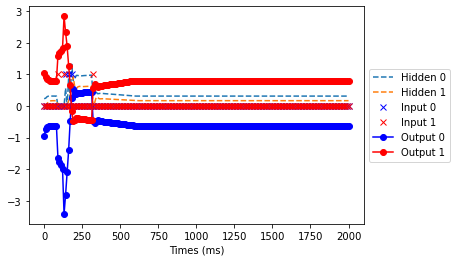

In [347]:
trial_i = 8
print("Ratio: ", trial_params[trial_i]['ratio']) 
times = np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0])
if training_kwargs['N_rec']==1:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden')
else:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden 0')
    plt.plot(times, hidden_states[trial_i, :, 1], '--', label='Hidden 1')
plt.plot(times, x[trial_i,:,0], 'xb', label='Input 0')
plt.plot(times, x[trial_i,:,1], 'xr', label='Input 1')

plt.plot(times, yhat[trial_i,:,0], '-ob', label='Output 0')
plt.plot(times, yhat[trial_i,:,1], '-or', label='Output 1')

# plt.plot(times, y[trial_i,:,0], 'ob')
# plt.plot(times, y[trial_i,:,1], 'or')
plt.xlabel("Times (ms)")
# plt.ylim([-7,7])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); # Put a legend to the right of the current axis
plt.savefig(training_kwargs['figures_path'] + '\\hiddenact_example_ratio%s.pdf'%(trial_params[trial_i]['ratio']))

In [348]:
if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
X_new = pca.fit_transform(flat_hidden_states)
X_new.shape

(2000000, 4)

In [349]:
# plt.figure(figsize=(6,6))
# plt.plot(X_new[:,0], X_new[:,1], '.')
# plt.xlabel("PC1")
# plt.ylabel("PC2");
# plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_ncomp%s.pdf'%(2))

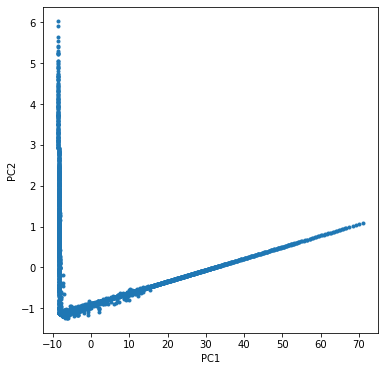

In [350]:
plt.figure(figsize=(6,6))
N_points = 5000
plt.plot(X_new[:N_points,0], X_new[:N_points,1], '.')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_small_ncomp%s.pdf'%(2))

In [351]:
coherence_array = np.array([[trial_params[i]['ratio']]*200 for i in range(len(trial_params))])
flat_coherence_array = coherence_array.reshape(-1)

vmin, vmax = np.min(flat_coherence_array), np.max(flat_coherence_array)
cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

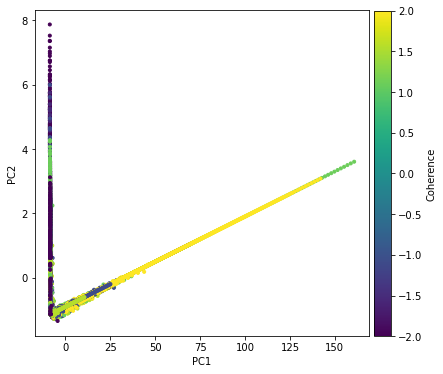

In [352]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# for i in range(X_new.shape[0]):
until = 50000
sc = plt.scatter(X_new[:until,0], X_new[:until,1], marker='.',
                 # levels=coherence_list,
                 vmin=vmin, vmax=vmax, color=scalarMap.to_rgba(flat_coherence_array[:until]))
plt.xlabel("PC1")
plt.ylabel("PC2");
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
cb_ax = fig.add_axes([.91,.124,.04,.754])
s_m.set_clim(vmin, vmax)
m = plt.colorbar(s_m, cax=cb_ax).set_label('Coherence',rotation=90)

plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_cohcolor_ncomp_%s.pdf'%(2))

In [353]:
direction_array = np.array([[trial_params[i]['ratio']<1.] for i in range(len(trial_params))])
flat_dir_array = direction_array.reshape(-1)

cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=np.min(flat_dir_array), vmax=np.max(flat_dir_array))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
bounds = [0,.5,1]

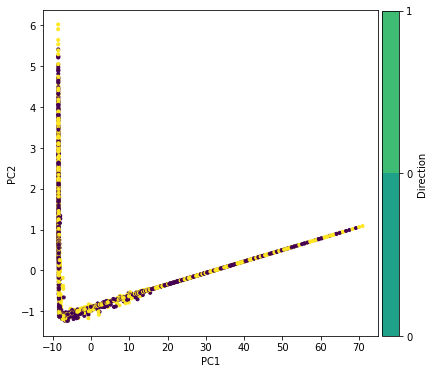

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# for i in range(X_new.shape[0]):
until = 5000
sc = plt.scatter(X_new[:until,0], X_new[:until,1], marker='.',
                 # levels=coherence_list,
                 vmin=vmin, vmax=vmax, color=scalarMap.to_rgba(flat_dir_array[:until]))
plt.xlabel("PC1")
plt.ylabel("PC2");
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
cb_ax = fig.add_axes([.91,.124,.04,.754])
s_m.set_clim(vmin, vmax)
cb = plt.colorbar(s_m, cax=cb_ax, cmap=cmap, norm=cNorm,
    spacing='proportional', ticks=[0, .5, 1], boundaries=bounds, format='%1i').set_label('Direction',rotation=90)
plt.savefig(training_kwargs['figures_path'] + '\\pca_dircolor_ncomp%s.pdf'%(2))

In [355]:
# y_res = y.reshape((-1,2))
# cmap = cm = plt.get_cmap('viridis') 
# cNorm  = colors.Normalize(vmin=np.min(y), vmax=np.max(y))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
# flat_coherence_array.shape

# plt.figure(figsize=(6,6))
# # for i in range(X_new.shape[0]):
# for i in range(5000):
#     plt.plot(X_new[i,0], X_new[i,1], '.', color=scalarMap.to_rgba(y_res[i,0]))
# plt.xlabel("PC1")
# plt.ylabel("PC2");
# s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
# # plt.colorbar(s_m)
# plt.title("Direction")
# plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_cohcolor_ncomp_%s.pdf'%(2))

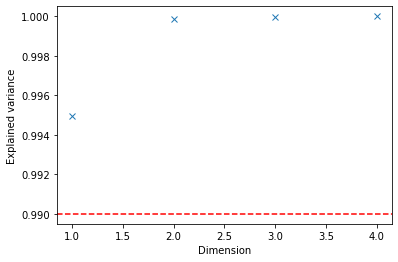

In [356]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.axhline(y=0.99, color = 'r', linestyle = '--')
# plt.axhline(y=0.999, color = 'r', linestyle = '--')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.savefig(training_kwargs['figures_path'] + '\\varexpl_cohlist.pdf')

Loading

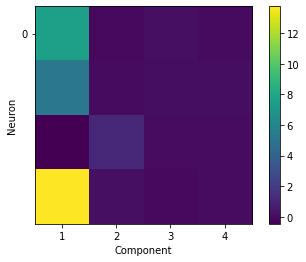

In [357]:
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.imshow(loading_matrix)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,training_kwargs['N_rec'], 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.colorbar()
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_cohlist.pdf')

In [358]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]

initial_feature_names = [i for i in range(training_kwargs['N_rec'])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_components)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_components)}
df = pd.DataFrame(dic.items())

print("Most important neurons")
df

Most important neurons


,0,1
0,PC0,3
1,PC1,2
2,PC2,0
3,PC3,1


In [359]:
def plot_cohdir_trajectories_2(trajectories, unstable_fixedpoint, trial_params, 
                               coherence_list, N_trial_plot=0, point_size = 2, label_text="Neuron",
                               cmaps=[plt.get_cmap('Blues') , plt.get_cmap('Reds')],
                               save_name='trajectories_fixedduronset_cohdir_condmean'):
    """
    Args: 
    N_trial_plot: to add N_trial_plot random trajectories
    
    """
    flat_trajectories = trajectories.reshape((-1, trajectories.shape[-1]))
    x_min, x_max = np.min(flat_trajectories[:,0]), np.max(flat_trajectories[:,0])
    y_min, y_max = np.min(flat_trajectories[:,1]), np.max(flat_trajectories[:,1])
    x_padding = (x_max-x_min)/10
    y_padding = (y_max-y_min)/10
    
    directions = np.array([np.where(trial_params[i]['ratio']>1.,1,0) for i in range(trial_params.shape[0])])
    ratios = np.array([np.abs(trial_params[i]['ratio']) for i in range(trial_params.shape[0])])
    
    fig, axes = plt.subplots(2, len(coherence_list), figsize=(10, 5), sharey=True, sharex=True)
    cmap1, cmap2 = cmaps 

    trials_per_cohanddir = [[[], []]]*len(coherence_list) #list of lists: per coherence, then perdirection
    for coh_i,coherence in enumerate(coherence_list):
        for direction in [0,1]:
            ax_idx = coh_i*2 + direction
            arr1 = np.where(ratios==coherence)[0]
            arr2 = np.where(directions==direction)[0]
            intersection = [idx for idx in arr1 if idx in arr2]
            for trial_i in intersection:
                    trials_per_cohanddir[coh_i][direction].append(trajectories[trial_i,:,:])
            # trials_per_cohanddir[coh_i][direction] = trajectories[intersection,:,:]

            # cond_mean = np.mean(trials_per_cohanddir[coh_i][direction], axis=0)
            cond_mean = np.mean(np.array(trials_per_cohanddir[coh_i][direction]), axis=0)
            sc = axes[direction, coh_i].scatter(cond_mean[:,0], cond_mean[:,1], s=1, marker='o',
                                           vmin=0, vmax=training_kwargs['T'], cmap=cmap2,
                                          c=np.linspace(0, training_kwargs['T'], hidden_states.shape[1]), zorder=3)

            if N_trial_plot>0:
                random_trials = np.random.choice(intersection, N_trial_plot)
                for trial_i in random_trials:
                    axes[direction, coh_i].plot(trajectories[trial_i,:,:][:,0], trajectories[trial_i,:,:][:,1],
                                                '-', color='0.8', linewidth=.5, zorder=1)
                    sc2 = axes[direction, coh_i].scatter(trajectories[trial_i,:,:][:,0],
                                     trajectories[trial_i,:,:][:,1],
                                     s=point_size, vmin=0, vmax=training_kwargs['T'], cmap=cmap1,
                                     c=np.linspace(0, training_kwargs['T'], trajectories.shape[1]), zorder=2)

            if np.all(unstable_fixedpoint) != None:
                axes[direction, coh_i].scatter(unstable_fixedpoint[0], unstable_fixedpoint[1], s=50, c='m', marker='x', zorder=2)
            if direction == 0:
                axes[direction, coh_i].set_title("%s"%coherence)

            axes[direction, coh_i].set_xlim([x_min-x_padding, x_max+x_padding])
            axes[direction, coh_i].set_ylim([y_min-y_padding, y_max+y_padding])
            axes[direction, coh_i].set_xlabel(label_text + " 1")
            if direction==0:
                axes[direction, coh_i].set_ylabel("Right \n \n "+label_text+" 2")
            else:
                axes[direction, coh_i].set_ylabel("Left \n \n "+label_text+" 2")

    cb_ax = fig.add_axes([.91,.124,.02,.754])
    cb_ax2 = fig.add_axes([.93,.124,.02,.754])
    fig.colorbar(sc, cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
    fig.colorbar(sc2, cax=cb_ax2, fraction=0.5, pad=0.04).set_label('Time (ms)',rotation=90)
    fig.supylabel('Direction')
    fig.suptitle("    Coherence")
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass
    
    if N_trial_plot>0:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'_examples.pdf', bbox_inches="tight")
    else:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'.pdf', bbox_inches="tight")

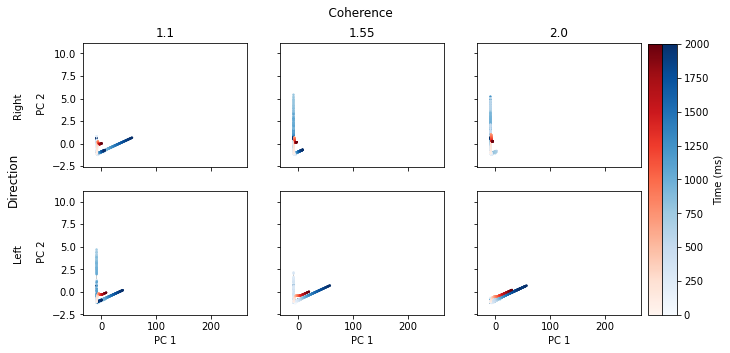

In [360]:
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
X_new = pca.fit_transform(flat_hidden_states)
trajectories = np.zeros((hidden_states.shape[0], 200, Nrec))

for trial_i in range(hidden_states.shape[0]):
    trajectories[trial_i, :,:] = pca.transform(hidden_states[trial_i,:,:])
    
coherence_list = np.linspace(min_ratio, max_ratio, 3)

plot_cohdir_trajectories_2(trajectories, None, trial_params, coherence_list, N_trial_plot=5,
                            label_text="PC", save_name='trajectories_cohdir_condmean_pc2')

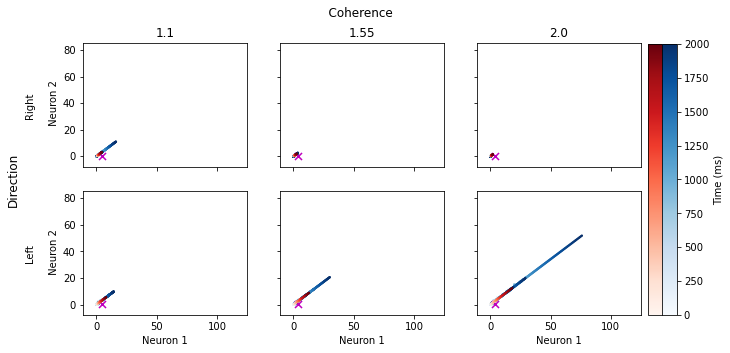

In [361]:
trajectories = hidden_states
plot_cohdir_trajectories_2(trajectories, unstable_fixedpoint, trial_params, coherence_list, N_trial_plot=5,
                            label_text="Neuron", cmaps=[plt.get_cmap('Blues'), plt.get_cmap('Reds')], save_name='trajectories_cohdir_condmean')

In [257]:
#same as above but with fixed stimulus durations (random from list)

#solution 2: create test set with discrete durations
training_kwargs['stim_durations'] = list(np.linspace(150, 750, 7))
training_kwargs['stim_durations'] = [500]
training_kwargs['onset_times'] = [200]

test_kwargs = training_kwargs 
test_kwargs['coherence_list'] = coherence_list
test_kwargs['coherence'] = None
N_test_batch = 5000
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=test_kwargs)
test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
test_set = [test_x, test_y, test_output_mask, test_trial_params]

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_pca_stimdur.pickle", 'wb') as handle:
#     pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_pca_stimdur.pickle", 'rb') as handle:
#     test_set = pickle.load(handle)
    
x, y, output_mask, trial_params = test_set

In [258]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [259]:
for unit_i in range(Nrec):
    plt.plot(range(0, 2000, 10), x[:5000,..., unit_i].T, 'b')
    plt.plot(range(0, 2000, 10), hidden_states[:5000,..., unit_i].T, 'r');
    plt.plot([0,inputs.shape[1]*10], [unstable_fixedpoint[unit_i], unstable_fixedpoint[unit_i]], 'g--')
    plt.xlabel("Time (ms)")
    plt.ylabel("Activity")
    plt.legend(["Input", "Hidden state", "Unstable fixed point"])
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('b')
    leg.legendHandles[1].set_color('r')
    leg.legendHandles[2].set_color('g')
    plt.savefig(training_kwargs['figures_path'] + '\\trajectories_unstable_fixedpoint_unit%s.pdf'%unit_i, bbox_inches="tight")

C:\Users\abel_\AppData\Local\Temp\ipykernel_3484\1759579440.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(training_kwargs['figures_path'] + '\\trajectories_unstable_fixedpoint_unit%s.pdf'%unit_i, bbox_inches="tight")
C:\Users\abel_\AppData\Local\Temp\ipykernel_3484\1759579440.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(training_kwargs['figures_path'] + '\\trajectories_unstable_fixedpoint_unit%s.pdf'%unit_i, bbox_inches="tight")
C:\Users\abel_\AppData\Local\Temp\ipykernel_3484\1759579440.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(training_kwargs['figures_path'] + '\\trajectories_unstable_fixedpoint_unit%s.pdf'%unit_i, bbox_inches="tight")
C:\Users\abel_\AppData\Local\Temp\ipykernel_3484\1759579440.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(tra

Error in callback <function flush_figures at 0x00000163440D8940> (for post_execute):



KeyboardInterrupt



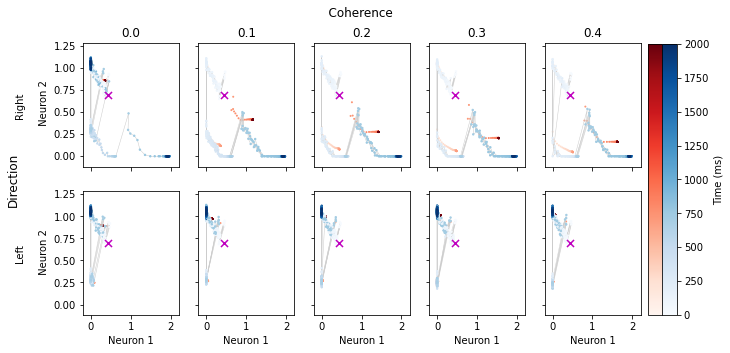

In [85]:
trajectories = hidden_states
plot_cohdir_trajectories_2(trajectories, unstable_fixedpoint, trial_params, coherence_list, N_trial_plot=5, point_size = 2,
                            label_text="Neuron", cmaps=[plt.get_cmap('Blues'), plt.get_cmap('Reds')], save_name='trajectories_fixedduronset_cohdir_condmean')